PPES2 - Python Programming in Energy Science 2 - University of Oldenburg - SoSe2025

### **Lecture 5: Advanced Plotting**

--------------------------------------

Martin Dörenkämper, martin.doerenkaemper@iwes.fraunhofer.de

07 May 2025

--------------------------------------




#### **Contents**
--------------------------------------
(0) Preparation

(1) Geospatial Coordinates and Transformation 

(2) Working with gridded data (here: _netCDF_)

(3) Plotting of maps with _cartopy_

(4) Short introduction to geopandas

----------------------------------------

### (0) Preparation: 

We will need a few new python libraries in this excercise that you should install for being able to execute this notebook and also do the excercises. I **strongly recommend to create a new environment** specifically for the plotting here, as this might have clashes with other libraries: 

`conda create -n geoplot`

`conda activate geoplot`

and then install the libraries that we need 

`conda install -c conda-forge geopandas`

`conda install -c conda-forge utm`

`conda install -c conda-forge xarray`

`conda install -c conda-forge netCDF4`

`conda install -c conda-forge cartopy`

`conda install -c ipykernel`


Besides this we will of course need `numpy`, `pandas` and `matplotlib`


### (1) Geospatial Coordinates and Transformation
In many renewable energy questions geospatial data are analysed which can occur in different formats. Most of you might know the Lat/Lon (WGS84) coordinates system. Thus, a site on earth is defined by a latitude (N/S) and longitude (E/W), so something like N 53.14, E 8.21 for Oldenburg. This system has the disadvantage that it include some curvature of the earth. Thus, 1 degree longitude has a geometrical different distance than at the equator, mid latitudes and the poles. Especially for smaller areas, a carthesian coordinate system is often needed for easier planning. Two examples that are often used are Gauß-Krüger (mainly Germany) and UTM coordinates (internationally). Python has different options to convert between the libraries:
- `pyproj`- A very powerful library to do differen conversions between 
- `utm`- A fast library for conversion of Lat/Lon coordinates to UTM

The UTM system splits the globe into different smaller carthesian areas (so called zones). The following image shows the zones in Europe.   
![title](./files/553px-LA2-Europe-UTM-zones.png)


In [1]:
# Example UTM library
import utm
import numpy as np

# Coordinates of Oldenburg and Bremen
oldenburg={"lat":53.14,"lon":8.21}
bremen={"lat":53.07,"lon":8.81}

# Conversion to karthesian Coordinate System
utmol=utm.from_latlon(oldenburg['lat'],oldenburg['lon'])
utmhb=utm.from_latlon(bremen['lat'],bremen['lon'])

# Calculate Distance between points (UTM has units m)
dist=np.sqrt((utmol[0]-utmhb[0])**2.0+(utmol[1]-utmhb[1])**2.0)

print("Oldenburg in UTM Koordinaten:")
print(utmol)
print("The Distance between Oldenburg and Bremen in km: "+str(dist/1e3))

Oldenburg in UTM Koordinaten:
(np.float64(447154.9281311009), np.float64(5888136.057239924), 32, 'U')
The Distance between Oldenburg and Bremen in km: 40.916783460988896


In [2]:
# Example pyproj libary
from pyproj import Proj

# Need to define reference code of the coordinate system you want to tranform to/from: https://spatialreference.org/ref/
outProj_utm=Proj('EPSG:32632') # UTM zone 32N https://spatialreference.org/ref/epsg/32632/
outProj_gk=Proj('EPSG:31466') # UTM 3 degree Gauß Krüger Zone 2 https://spatialreference.org/ref/epsg/31466/

# Re Conversion from UTM to Lat/Lon
[lonol,latol]=outProj_utm(utmol[0],utmol[1],inverse=True)
print([lonol,latol])

# Convert Oldenburg and Bremen to Gauß-Krüger and Calculate Distance Again
gkol=outProj_gk(oldenburg['lat'],oldenburg['lon'])
gkhb=outProj_gk(bremen['lat'],bremen['lon'])
print(gkol)
print(gkhb)

[8.209999999918407, 53.140000004308924]
(8368431.848825396, 1329098.0500448472)
(8342050.339003728, 1422704.316537806)


### (2) Working with gridded data (here: _netCDF_)
In many energy related questions spatial information (e.g. maps) are investigated and needed. This could e.g. be the investigation of precipitation variation over an area and over time (e.g. for hydro power), a wind atlas for investigation the most suitable sites over an area or also e.g. time and space varying cloud cover for solar power questions. These data often have 4 dimensions (time, height, latitude, longitude) and can be very very very large. 

Two data formats are very common for these weather / climate data:

- `GRIB` - (GRIdded Binary) ist a standardised data file format by the World Meteorological Organisation that is responsible for guiding the collection, delivery and use of climate, weather and hydrological data. All national weather services use GRIB data files to exchange forecast data. GRIB provides a very high compresssion and is thus suited for weather model data that is typically very large. For reading a GRIB file, an additional GRIB table or information on how the data is stored is needed that describes the grid, attributes and variables inside the file. Python can do this for us, if the file is following conventions. 

- `NetCDF` - (Network Common Data Form) is a machine independent data format that supports the access, sharing and creation of array-oriented scientific data. It is a community standard for sharing scientific data. In recent years more and more scientific data is shared in this format. A good NetCDF file is fully self descriptive. Thus, besides e.g. the data from a weather model it also can contain the information of the setup, on which machines it was executed etc. So, you can provide all information that a user possibly needs in the end. 

For both data fromats libraries/interfaces in most common programming languages exist (C/C++/Fortran/MATLAB/Python/R etc.). Both data formats compress the data internally to some degree and store it in a binary format. Thus, you cannot "open" the files with a text viewer but need a special tool, or a python library :-) for this. We will look at examples here and focus on reading and writing netCDF files. There are tons of examples on the web on how to work with GRIB files in case you are interested. 

- You might want to have a look at python CDO module, or LINUX tools like ncdump, ncview when working with netcdf data in more detail.



#### (2.1) The xarray package

In [7]:
import xarray as xr

# Read NETCDF File
ncf = './files/ERA5_atm_20250401_winds.nc' #example filename
nci=xr.open_dataset(ncf, engine="netcdf4")

# Print all variables in file
nci.keys()


KeysView(<xarray.Dataset> Size: 199MB
Dimensions:     (valid_time: 24, longitude: 1440, latitude: 721)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2025-04-01 ... 2025-04-01T23...
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    u100        (valid_time, latitude, longitude) float32 100MB ...
    v100        (valid_time, latitude, longitude) float32 100MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.2.4 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Thu Apr 24 14:26:23 2025: cdo -selvar,u100,v100 ...
    CDO:                     Climate Data Operators version 2.2.2 (https://mp...)

In [4]:
# Access the Variable u10 (u compontent of wind speed at 10m)
nci.u100.values.shape

(24, 721, 1440)

In [5]:
nci.u100.values

array([[[-2.921463  , -2.921463  , -2.921463  , ..., -2.921463  ,
         -2.921463  , -2.921463  ],
        [ 5.292404  ,  5.2982635 ,  5.304123  , ...,  5.266037  ,
          5.274826  ,  5.283615  ],
        [ 5.2738495 ,  5.281662  ,  5.2914276 , ...,  5.2318573 ,
          5.248459  ,  5.2631073 ],
        ...,
        [ 0.04142761,  0.04728699,  0.05705261, ...,  0.02287292,
          0.03166199,  0.03849792],
        [ 1.141037  ,  1.1478729 ,  1.1537323 , ...,  1.1263885 ,
          1.1312714 ,  1.1361542 ],
        [-1.2769318 , -1.2769318 , -1.2769318 , ..., -1.2769318 ,
         -1.2769318 , -1.2769318 ]],

       [[-2.6638641 , -2.6638641 , -2.6638641 , ..., -2.6638641 ,
         -2.6638641 , -2.6638641 ],
        [ 5.188675  ,  5.1945343 ,  5.2013702 , ...,  5.1603546 ,
          5.1701202 ,  5.1789093 ],
        [ 5.2072296 ,  5.2169952 ,  5.2277374 , ...,  5.1632843 ,
          5.1808624 ,  5.1964874 ],
        ...,
        [ 0.1632843 ,  0.16719055,  0.17500305, ...,  

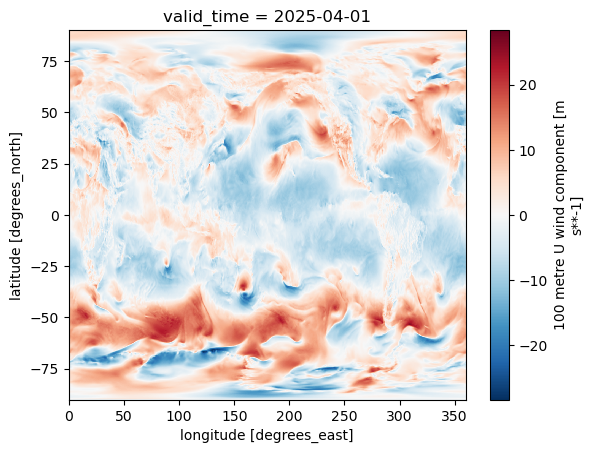

In [10]:
# Create Plot to get a quick overview (time step 0 utc)
nci.u100[0,:,:].plot() # Plot Sea Surface Temperature

{'lat': 53.14, 'lon': 8.21}


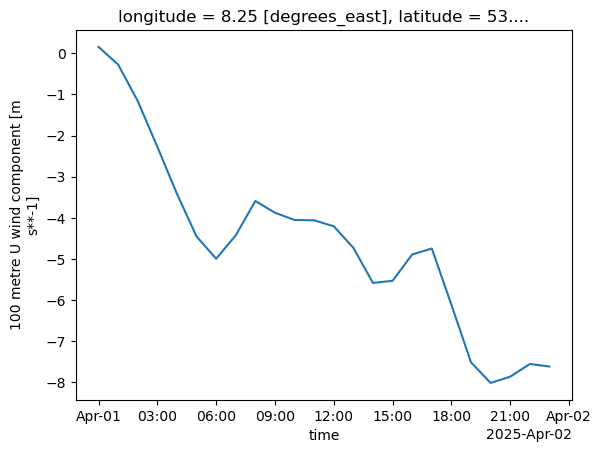

In [8]:
# Select Point around Oldenburg of 2m temperature
print(oldenburg)
wsts=nci.u100.sel(latitude=oldenburg["lat"],longitude=oldenburg["lon"],method="nearest")[:]
wsts.plot()

In [11]:
# Convert Data to Pandas DataFrames
pdfws=wsts.to_pandas()
pdfws.values

array([ 0.1537323 , -0.27519226, -1.1610565 , -2.2732544 , -3.4165802 ,
       -4.453186  , -4.9943237 , -4.4252167 , -3.590973  , -3.8764648 ,
       -4.052429  , -4.0606384 , -4.2057343 , -4.72995   , -5.583496  ,
       -5.5303497 , -4.8908997 , -4.7460175 , -6.1130066 , -7.5124817 ,
       -8.012833  , -7.860489  , -7.552597  , -7.614517  ], dtype=float32)

In [15]:
import pandas as pd
# Write Data to new File

# Create Pandas Dataframe
pdfout=pd.DataFrame({"u100":pdfws.values},index=pdfws.index)

ncj=xr.Dataset.from_dataframe(pdfout)

ncj.attrs['Author'] = 'Created in Python Class'
ncj.attrs['Date_created'] = "2025-05-07" # Attributes must be string / number / ndarray (no datetime) 
ncj.attrs['Institution'] = 'University of Oldenburg'
ncj.u100.attrs['units'] = 'ms-1'
ncj.u100.attrs['long_name'] = "Wind Speed (u-component) at 100m height above ground in Oldenburg"

ncj.to_netcdf("ERA5-u100-20250401.nc")
ncj.close()

nci.close() # Important you should always have this at the end (!)


#### (2.1) The netCDF4 Package

Ususally the `xarray` package is more powerful when working with gridded / array data also from `netCDF` files. However, there is another package `netCDF4` that supports further features like groups. 

In [25]:
import netCDF4 as nc

nci=nc.Dataset("./files/ERA5_atm_20250401_winds.nc")
nci["u100"].shape


(24, 721, 1440)

In [26]:
nci["u100"][:,360,720]

masked_array(data=[-3.1587677, -3.2615204, -3.4579315, -3.4412231,
                   -3.7261505, -3.968811 , -4.3224487, -4.623459 ,
                   -4.8370667, -5.338379 , -4.5631714, -5.0205994,
                   -5.5514374, -5.644989 , -5.8012695, -5.768631 ,
                   -5.4983215, -5.9217987, -6.4098816, -6.9148254,
                   -7.170059 , -7.181778 , -6.385605 , -6.0715485],
             mask=False,
       fill_value=np.float64(1e+20),
            dtype=float32)

In [27]:
ws=nci["u100"][:,360,720].data

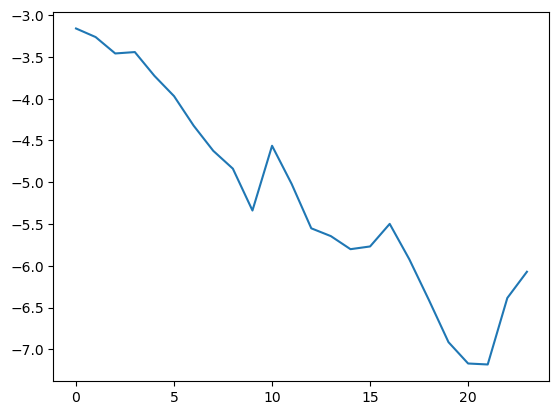

In [28]:
import matplotlib.pyplot as plt
plt.plot(nci["u100"][:,360,720].data)

In [29]:
nci.close()

### (3) Plotting of Maps with `cartopy`

Python provides different opportunities to plot maps of (parts of) the earth. 

- Why do we need a library for map plotting?
As the earth is a sphere, any attempt to project this or parts of the earth into the 2D space (e.g. creating a two dimensional plot) needs some map projection functions. I recommend this xkcd if you want to learn what map projection person you are: https://xkcd.com/977/

- What is the challenge? 
We need to read our data we want to plot on a map and transform it in the same projection as it was created onto the map we want to plot. Luckily good netCDF files (look above) contain all of this information needed as attributes. 




c:\Users\nuwaw\miniforge3\envs\geoplot\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


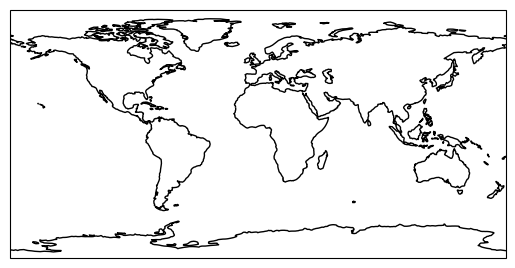

In [30]:
# "Hello World" - example of a simple map of the earth in PlateCarree projection
# Note that the plotting of maps can take some time (up to 1-2 minutes) depending on the resolution of coastline and other information we need to load and read

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.show()

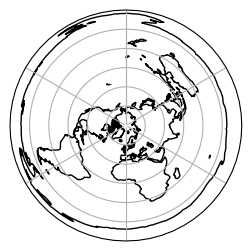

In [31]:
# Change the projection to AzimuthalEquidistant
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(3, 3))
ax = plt.axes(projection=ccrs.AzimuthalEquidistant(central_latitude=90))
ax.coastlines(resolution='110m')
ax.gridlines()


Note what difference a simple projection can make. In https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#cartopy-projections you can find a list of
all projections available in cartopy. Lets have a look at more complex examples. 

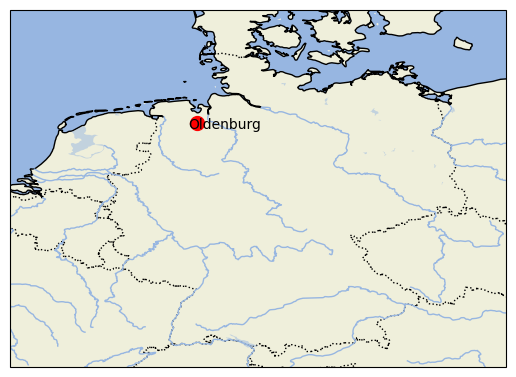

In [36]:
# Plot a map of Germany with a Marker for Oldenburg
# We use the "standard" PlateCarree projection

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([3.5, 16, 47, 56], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND) # colorize Land
ax.add_feature(cfeature.OCEAN) # colorize Ocean
ax.add_feature(cfeature.COASTLINE) # add Coastline
ax.add_feature(cfeature.BORDERS, linestyle=':') # add Borderlines 
ax.add_feature(cfeature.LAKES, alpha=0.5) # add Lakes
ax.add_feature(cfeature.RIVERS) # add large Rivers (Danube only here)
ax.plot(8.21,53.14,"ro",ms=10) # Add a marker...
ax.text(8,53,"Oldenburg") # and a text for Oldenburg
plt.show()


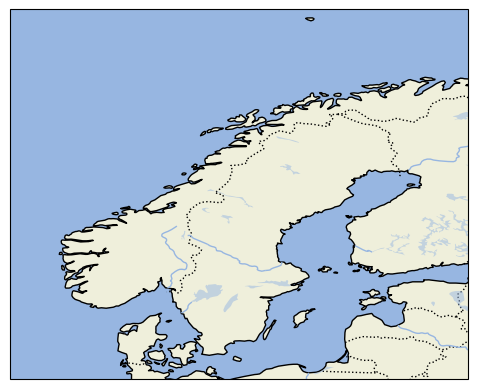

In [40]:
# Plot a map of Norway 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([2, 28, 54, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND) # colorize Land
ax.add_feature(cfeature.OCEAN) # colorize Ocean
ax.add_feature(cfeature.COASTLINE) # add Coastline
ax.add_feature(cfeature.BORDERS, linestyle=':') # add Borderlines 
ax.add_feature(cfeature.LAKES, alpha=0.5) # add Lakes
ax.add_feature(cfeature.RIVERS) # add large Rivers (Danube only here)
plt.show()


Do you like this projection? I don't. It looks so "squeezed" in north-south direction. So lets go for something we are a bit more used to, the Lambert Conformal projection

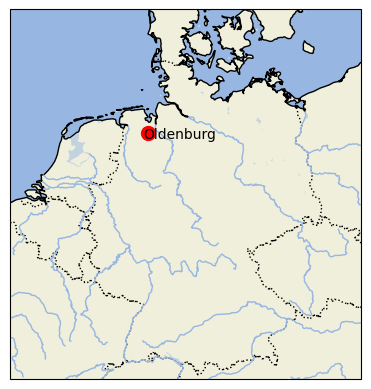

In [42]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

proj1=ccrs.LambertConformal(central_longitude=10.0, central_latitude=51, standard_parallels=(48, 54)) # neet to specify a central longitude/latitude 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=proj1)
ax.set_extent([3.5, 16, 47, 56])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.text(8,53,"Oldenburg",transform=ccrs.PlateCarree())
ax.plot(8.21,53.14,"ro",ms=10,transform=ccrs.PlateCarree())
plt.show()


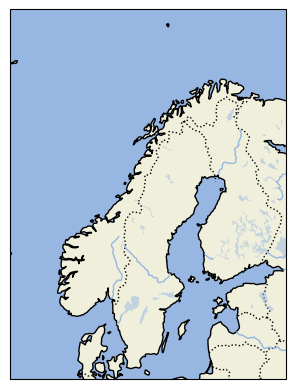

In [43]:
# Norway
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

proj1=ccrs.LambertConformal(central_longitude=15.0, central_latitude=65, standard_parallels=(60,70)) # neet to specify a central longitude/latitude 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=proj1)
ax.set_extent([2, 28, 54, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
plt.show()

Lets do some more fancy stuff and add some data to our plots, we have some gridded data from the previous section that we could add to the map here. 

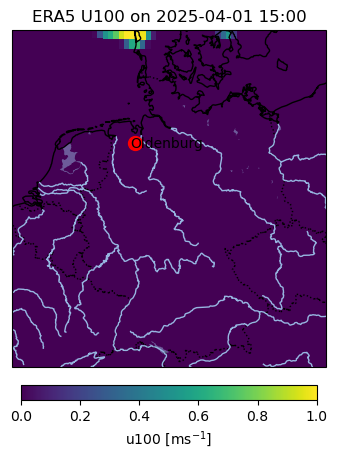

In [45]:
import xarray as xr
import datetime
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

proj1=ccrs.LambertConformal(central_longitude=10.0, central_latitude=51)

ncf = './files/ERA5_atm_20250401_winds.nc'  #example filename
nci=xr.open_dataset(ncf)

nci

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=proj1)
ax.set_extent([3.5, 16, 47, 56])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
im=ax.pcolormesh(nci.longitude,nci.latitude,nci.u100[12,:,:].values,vmin=0.0,vmax=1,transform=ccrs.PlateCarree())
#im=ax.pcolormesh(nci.longitude,nci.latitude,nci.u100[12,:,:].values,vmin=0.0,vmax=15.0,transform=ccrs.PlateCarree())
ax.text(8,53,"Oldenburg",transform=ccrs.PlateCarree())
ax.plot(8.21,53.14,"ro",ms=10,transform=ccrs.PlateCarree())
t = nci.valid_time[15].values
ts = pd.to_datetime(str(t)) 
d = ts.strftime('%Y-%m-%d %H:%M')
ax.set_title("ERA5 U100 on "+d)
fig.colorbar(im, ax=ax, label="u100 [ms$^{-1}$]", fraction=0.04, pad=0.05, orientation="horizontal")
plt.show()
nci.close()

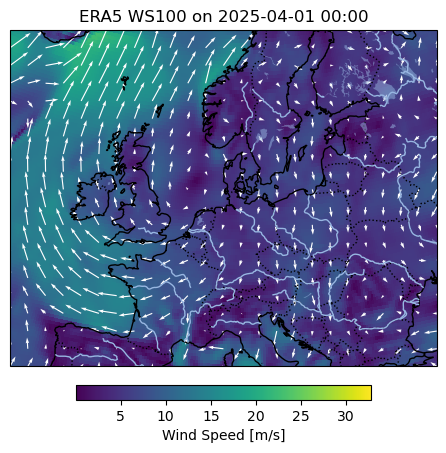

In [46]:
# For Winds we might want to have arrow for the wind direction 
import xarray as xr
import datetime
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

proj1=ccrs.LambertConformal(central_longitude=10.0, central_latitude=51)

ncf = './files/ERA5_atm_20250401_winds.nc' #example filename
nci=xr.open_dataset(ncf)

i0=0 # Time step 0
u100=nci.u100[i0,:,:].values
v100=nci.v100[i0,:,:].values

ws100=np.sqrt(u100*u100+v100*v100) # Calculate absolute wind speed at 10m
lons=nci.longitude.values # read longitudes
lats=nci.latitude.values # read latitutes

t = nci.valid_time[i0].values # read time step and transform to datestring
ts = pd.to_datetime(str(t)) 
dstr = ts.strftime('%Y-%m-%d %H:%M')

# Plot the figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=proj1)
ax.set_extent([-13, 30, 40, 65])
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
im=ax.pcolormesh(lons,lats,ws100,transform=ccrs.PlateCarree())
ax.quiver(lons,lats,u100,v100,transform=ccrs.PlateCarree(),color="white",regrid_shape=20) # Regrid shape controls density of arrows
ax.set_title("ERA5 WS100 on "+dstr)
fig.colorbar(im, ax=ax, label="Wind Speed [m/s]", fraction=0.04, pad=0.05, orientation="horizontal")

plt.show()

nci.close()


### (4) Short introduction to `geopandas`

The geopandas library is a very neat library to work with geospatial data. We will show a couple of useful examples to work with shapefiles. Shapefiles are very very common. Attention, a shapefile consists of multiple files, 
that define projection and datapoints saparately. 

However, geopandas can do a lot more. Examples can be found in the geopandas library: https://geopandas.org/en/stable/gallery/index.html


In [47]:
import geopandas as gpd

In [48]:
# Read a Shapefile
DEU_shp = gpd.read_file("./files/DEU_adm1.shp")


In [49]:
DEU_shp

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
0,86,DEU,Germany,1,Baden-Württemberg,None,None,Land,State,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,86,DEU,Germany,2,Bayern,None,Bavaria,Land,State,"POLYGON ((10.13386 50.55, 10.1398 50.54252, 10..."
2,86,DEU,Germany,3,Berlin,None,None,Land,State,"POLYGON ((13.16181 52.59442, 13.174 52.59425, ..."
3,86,DEU,Germany,4,Brandenburg,None,None,Land,State,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,86,DEU,Germany,5,Bremen,None,None,Land,State,"POLYGON ((8.98545 53.12822, 8.97316 53.12799, ..."
5,86,DEU,Germany,6,Hamburg,None,None,Land,State,"POLYGON ((10.07162 53.71823, 10.0715 53.72192,..."
6,86,DEU,Germany,7,Hessen,None,Hesse,Land,State,"POLYGON ((9.49877 51.63152, 9.50474 51.62795, ..."
7,86,DEU,Germany,8,Mecklenburg-Vorpommern,None,Mecklenburg-West Pomerania,Land,State,"MULTIPOLYGON (((14.26472 53.71069, 14.26472 53..."
8,86,DEU,Germany,9,Niedersachsen,None,Lower Saxony,Land,State,"MULTIPOLYGON (((6.86528 53.59597, 6.86528 53.5..."
9,86,DEU,Germany,10,Nordrhein-Westfalen,None,North Rhine-Westphalia,Land,State,"POLYGON ((8.66628 52.52528, 8.67277 52.51795, ..."


In [50]:
# Select State of Lower Saxony
DEU_shp[DEU_shp["NAME_1"]=="Niedersachsen"]

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
8,86,DEU,Germany,9,Niedersachsen,None,Lower Saxony,Land,State,"MULTIPOLYGON (((6.86528 53.59597, 6.86528 53.5..."


In [51]:
# Convert everything to UTM Coordinates
DEU_shp[DEU_shp["NAME_1"]=="Niedersachsen"].to_crs("EPSG:25832")

,ID_0,ISO,NAME_0,ID_1,NAME_1,NL_NAME_1,VARNAME_1,TYPE_1,ENGTYPE_1,geometry
8,86,DEU,Germany,9,Niedersachsen,None,Lower Saxony,Land,State,"MULTIPOLYGON (((358728.077 5940689.643, 358727..."


In [55]:
nds_center=DEU_shp[DEU_shp["NAME_1"]=="Niedersachsen"].centroid

C:\Users\nuwaw\AppData\Local\Temp\ipykernel_26092\3432418218.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nds_center=DEU_shp[DEU_shp["NAME_1"]=="Niedersachsen"].centroid


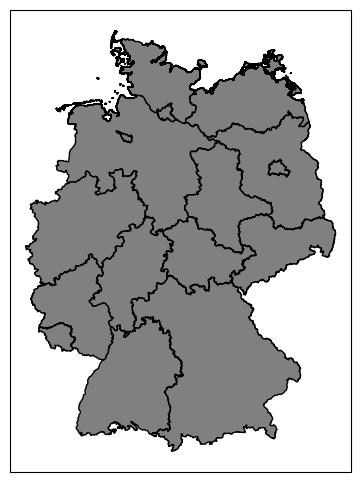

In [57]:
# Add that to a plot 

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

proj1=ccrs.LambertConformal(central_longitude=10, central_latitude=51)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection=proj1)
DEU_shp.plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='black', facecolor='grey',aspect=None)

plt.show()

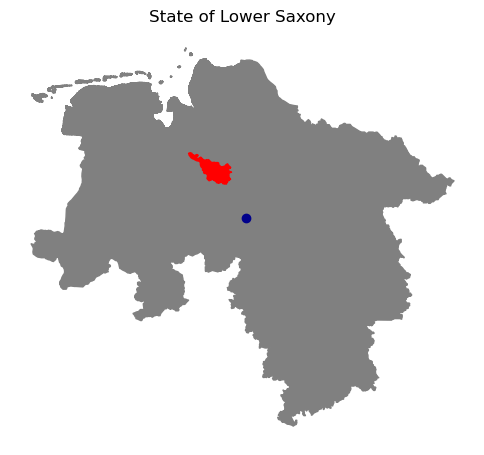

In [59]:
# Add that to a plot 

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

proj1=ccrs.LambertConformal(central_longitude=10, central_latitude=51)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection=proj1)
DEU_shp[DEU_shp["NAME_1"]=="Niedersachsen"].plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='grey', facecolor='grey',aspect=None)
DEU_shp[DEU_shp["NAME_1"]=="Bremen"].plot(ax=ax, legend=True, transform=ccrs.PlateCarree(),edgecolor='red', facecolor='red',aspect=None)
ax.scatter(nds_center.x,nds_center.y,transform=ccrs.PlateCarree(),color="darkblue") # Centerpoint of Lower Saxony
ax.axis('off') # Switch off the Frame 
ax.set_title(f"State of Lower Saxony")
plt.show()